In [22]:
import os
import itertools
import matplotlib as mpl


def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    From: https://jwalton.info/Embed-Publication-Matplotlib-Latex/

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim


width, height = set_size(252, fraction=1.0)
widht = 2 * width

fontsize = 9

mpl.rcParams.update(
    {
        "font.size": fontsize,
        "figure.figsize": (width, height),
        "figure.facecolor": "white",
        "savefig.dpi": 360,
        "figure.subplot.bottom": 0.125,
        "figure.edgecolor": "white",
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
    }
)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

from tqdm.notebook import tqdm

from deephyper.skopt.moo import pareto_front, non_dominated_set, hypervolume
from deephyper.skopt.utils import cook_objective_scaler
from deephyper.analysis import rank

In [53]:
import matplotlib.ticker as ticker


@ticker.FuncFormatter
def minute_major_formatter(x, pos):
    x = float(f"{x/60:.2f}")
    if x % 1 == 0:
        x = str(int(x))
    else:
        x = f"{x:.2f}"
    return x

In [65]:
tasks = ["mnist"]
objective_columns = ["objective_0", "objective_1", "objective_2"]
n_objectives = len(objective_columns)
# solvers = ["dhmml", "dhquc", "nsgaii", "tpe", "random", "parmoo"]
solvers = ["dhmml", "dhqu", "nsgaii", "tpe", "random"]
nodes = [10, 20, 30, 40]
repetitions = list(range(5))
t_max = 3600 * 2.5
times = np.linspace(0, t_max, 1_000)

In [66]:
def load_data_from_task(task_name):

    df_results = []

    for solver, node, i in itertools.product(solvers, nodes, repetitions):
        pdir = "../multiobjective/jahs-mnist/results/"
        path = os.path.join(pdir, f"jahs-{solver}-{node}-{i}/results.csv")

        if not (os.path.exists(path)):
            print(f"Skipping: {path} because not found.")
            continue

        source_df = pd.read_csv(path)
        soruce_df = source_df.sort_values(by="m:timestamp_end", ascending=True)
        source_df["m:timestamp_end"] = (
            source_df["m:timestamp_end"] - source_df["m:timestamp_start"].min()
        )

        f0 = interp1d(
            source_df["m:timestamp_end"],
            source_df["objective_0"],
            kind="previous",
            bounds_error=False,
            fill_value=0,
        )
        f1 = interp1d(
            source_df["m:timestamp_end"],
            source_df["objective_1"],
            kind="previous",
            bounds_error=False,
            fill_value=0,
        )
        f2 = interp1d(
            source_df["m:timestamp_end"],
            source_df["objective_2"],
            kind="previous",
            bounds_error=False,
            fill_value=0,
        )

        df = pd.DataFrame(
            {
                "times": times,
                "objective_0": f0(times),
                "objective_1": f1(times),
                "objective_2": f2(times),
                "solver": solver,
                "node": node,
                "repetition": i,
            }
        )

        df_results.append(df)

    df = pd.concat(df_results, ignore_index=True)
    df["task"] = task_name

    return df

In [67]:
# TODO: missing jahs-dhquc and parmoo
# Load data
df = pd.concat(
    [load_data_from_task(task_name) for task_name in tasks], ignore_index=True
)

## Check Objectivating Scaling

Id


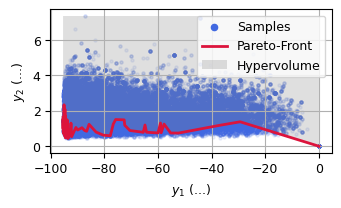

MML


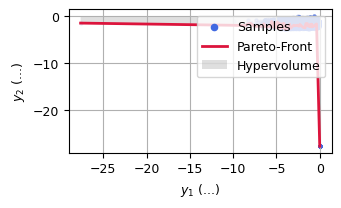

QU


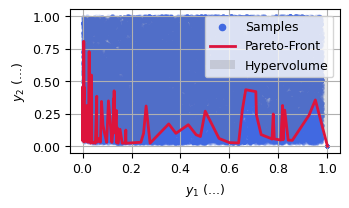

In [68]:
scalers = {"identity": "Id", "minmaxlog": "MML", "quantile-uniform": "QU"}

for scaler_key, scaler_label in scalers.items():
    
    print(scaler_label)

    # Load data
    df = pd.concat(
        [load_data_from_task(task_name) for task_name in tasks], ignore_index=True
    )

    # Scale data
    scaler = cook_objective_scaler(scaler_key, None)
    for (task_name,), group_df in df.groupby(["task"]):
        df.loc[group_df.index, objective_columns] = scaler.fit_transform(
            -group_df[objective_columns].values
        )

    for (task_name,), group_df in df.groupby(["task"]):
        objectives = group_df[objective_columns].values
        pf = pareto_front(objectives, sort=True)
        ref = np.max(objectives, axis=0)
        hv_x = pf[:, 0].tolist()
        hv_y = pf[:, 1].tolist()
        hv_x = [ref[0]] + [hv_x[0]] + hv_x + [ref[0]] + [ref[0]]
        hv_y = [ref[1]] + [ref[1]] + hv_y + [hv_y[-1]] + [ref[1]]
        plt.figure() 
        plt.scatter(objectives[:,0], objectives[:, 1], color="royalblue", s=5, alpha=0.1, label="Samples")
        plt.plot(pf[:,0], pf[:, 1], color="crimson", linewidth=2, label="Pareto-Front")
        plt.fill(hv_x, hv_y, facecolor="gray", edgecolor="none", alpha=0.25, linewidth=2, label="Hypervolume")
        plt.xlabel(r"$y_1$ (...)")
        plt.ylabel(r"$y_2$ (...)")

        # handles, labels =  plt.gca().get_legend_handles_labels()
        # handle_scatter = mpatches.Patch(color=handles[0].get_facecolor(), label=handles[0].get_label())
        # handles[0] = handle_scatter

        legend = plt.legend(loc="upper right")
        legend.legend_handles[0].set_sizes([20])
        legend.legend_handles[0].set_alpha(1)

        plt.grid()
        plt.tight_layout()
        plt.savefig(f"output/jahsbench/figures/scaler_{scaler_key}_{task_name}.png", dpi=300)
        plt.show() 

    # break

## Check Ranking & Average

In [74]:
# Scale objectives to be uniformly distributed in [0, 1]

# Load data
df = pd.concat(
    [load_data_from_task(task_name) for task_name in tasks], ignore_index=True
)

scaler = cook_objective_scaler("quantile-uniform", None)
for (task_name,), group_df in df.groupby(["task"]):
    df.loc[group_df.index, objective_columns] = scaler.fit_transform(-group_df[objective_columns].values)

In [75]:
ref_point = scaler.transform([[-88, 1.0, 1.0]])[0]
ref_point[1] = 1.0
ref_point[2] = 1.0
ref_point

array([0.44494117, 1.        , 1.        ])

In [76]:
def hypervolume_curve(y, ref_point):
    assert np.shape(y)[1] == np.shape(ref_point)[0]

    hv = []
    for i in range(len(y)):
        pf = pareto_front(y[: i + 1])
        hv.append(hypervolume(pf, ref=ref_point))
    return hv

In [81]:
# Compute the hypervolume curve
df["hypervolume"] = None
for group_values, group_df in tqdm(df.groupby(["task", "solver", "node", "repetition"])):
    hv = hypervolume_curve(group_df[objective_columns].values, ref_point=ref_point)
    df.loc[group_df.index, "hypervolume"] = hv

  0%|          | 0/100 [00:00<?, ?it/s]

In [83]:
solver_linestyle = {
    "dhmml": "--",
    "dhquc": "--",
    "dhqu": "--",
    "nsgaii": "-",
    "tpe": "-",
    "random": "-",
}

color_mapping = {
    # 10
    "Random-10": "gainsboro",
    "NSGAII-10": "lightcoral",
    "MoTPE-10": "plum",
    "D-MoBO (QU)-10": "lightgreen",
    # 20
    "Random-20": "lightgray",
    "NSGAII-20": "coral",
    "MoTPE-20": "violet",
    "D-MoBO (QU)-20": "limegreen",
    # 30
    "Random-30": "gray",
    "NSGAII-30": "orangered",
    "MoTPE-30": "orchid",
    "D-MoBO (QU)-30": "seagreen",
    # 40
    "Random-40": "black",
    "NSGAII-40": "crimson",
    "MoTPE-40": "purple",
    "D-MoBO (QU)-40": "darkgreen",
}

label_mapping = {
    "dhmml": "D-MoBO (MML)",
    "dhquc": "D-MoBO (QU+C)",
    "dhqu": "D-MoBO (QU)",
    "nsgaii": "NSGAII",
    "tpe": "MoTPE",
    "random": "Random",
}
nodes = [10, 20, 30, 40]

task_rankings.shape=(5, 8, 1000)
task_scores.shape=(5, 8, 1000)


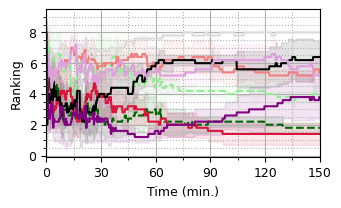

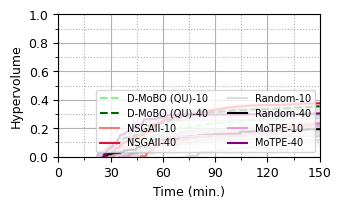

In [84]:
filter = df["node"].isin([10, 40]) & (
    df["solver"].isin(["dhqu", "nsgaii", "tpe", "random"])
)

task_rankings = []
task_scores = []
for labels, group_df in df[filter].groupby(["task", "repetition"]):
    group_labels = []
    group_hv = []
    for gv, gdf in group_df.groupby(["solver", "node"]):
        group_labels.append(gv)
        group_hv.append(gdf["hypervolume"].values)

    group_hv = np.array(group_hv)

    # Ranking which takes into account ties given a tolerance
    ranks = np.zeros_like(group_hv).astype(int)
    for i in range(group_hv.shape[1]):
        r = group_hv.shape[0] - rank(group_hv[:, i], decimals=5) + 1
        ranks[:, i] = r

    task_scores.append(group_hv)
    task_rankings.append(ranks)

task_rankings = np.array(task_rankings).astype(float)
task_scores = np.array(task_scores).astype(float)

print(f"{task_rankings.shape=}")
print(f"{task_scores.shape=}")

conf = 1.96
n = task_rankings.shape[0]

average_rankings = np.mean(task_rankings, axis=0)
stde_rankings = conf * np.std(task_rankings, axis=0) / np.sqrt(n)

average_scores = np.mean(task_scores, axis=0)
stde_scores = conf * np.std(task_scores, axis=0) / np.sqrt(n)

plt.figure()
for i, label in enumerate(group_labels):
    solver, node = label
    flabel = f"{label_mapping[solver]}-{node}"

    x = times
    plt.plot(
        x,
        average_rankings[i],
        linestyle=solver_linestyle.get(solver, "-"),
        color=color_mapping[flabel],
        label=flabel,
    )
    plt.fill_between(
        x,
        average_rankings[i] - stde_rankings[i],
        average_rankings[i] + stde_rankings[i],
        alpha=0.1,
        color=color_mapping[flabel],
    )
plt.xlabel("Time (min.)")
plt.ylabel("Ranking")
plt.grid(True, which="major")
plt.grid(True, which="minor", linestyle=":")
plt.xlim(min(times), max(times))

ax = plt.gca()
ticker_freq = t_max / 5
ax.xaxis.set_major_locator(ticker.MultipleLocator(ticker_freq))
ax.xaxis.set_major_formatter(minute_major_formatter)
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(ticker_freq / 2))

plt.tight_layout()
plt.savefig("output/jahsbench/figures/average_ranking.png", dpi=360)
plt.show()

plt.figure()

for i, label in enumerate(group_labels):
    solver, node = label
    flabel = f"{label_mapping[solver]}-{node}"

    x = times
    plt.plot(
        x,
        average_scores[i],
        linestyle=solver_linestyle.get(solver, "-"),
        color=color_mapping[flabel],
        label=flabel,
    )
    plt.fill_between(
        x,
        average_scores[i] - stde_scores[i],
        average_scores[i] + stde_scores[i],
        alpha=0.1,
        color=color_mapping[flabel],
    )
plt.ylim(0, 1)
plt.xlabel("Time (min.)")
plt.ylabel("Hypervolume")
plt.legend(ncols=2, loc="lower right", fontsize=7)
plt.grid(True, which="major")
plt.grid(True, which="minor", linestyle=":")
plt.xlim(min(times), max(times))

ax = plt.gca()
ticker_freq = t_max / 5
ax.xaxis.set_major_locator(ticker.MultipleLocator(ticker_freq))
ax.xaxis.set_major_formatter(minute_major_formatter)
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(ticker_freq / 2))

plt.tight_layout()
plt.savefig("output/jahsbench/figures/average_hypervolume.png", dpi=360)
plt.show()